In [7]:
# Data
import numpy as np

# if __name__ == '__main__':
with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}
    
    X = [char_to_idx[x] for x in txt]
    X = np.array(X)
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [8]:
# Model
import impl.layer as l

class RNN:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(H / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))
    
    def forward(self, X, h, m):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        h_in = h.copy()
        X_in = X.copy()
    
        X = (X_in @ Wxh) + (h_in @ Whh) + bh
        h, h_cache = l.tanh_forward(X)
        y, y_cache = l.fc_forward(h, Why, by)
        
        cache = (X_in, Wxh, h_in, Whh, h_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        X_in, Wxh, h_in, Whh, h_cache, y_cache = cache

        dh_out = dh.copy()
        
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dX = l.tanh_backward(dh, h_cache)

        dbh = dX * 1.0
        dWhh = h_in.T @ dX
        dWxh = X_in.T @ dX
        
        dX_in = dX @ Wxh.T
        dh_in = dX @ Whh.T
        
        dX = dX_in
        dh = dh_in

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy() # Output of previous layer == input of next layer
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy() # The input for the next layer is the output for the previous layer
            dXs.append(dX)
            
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [9]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    eps = 1e-8
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    # Epochs
    for iter in range(1, n_iter + 1):
        # Minibatches
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
    
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=100)
            print(sample)
            
    return nn

Iter-10 loss: 96.4800
et in b ei in'tnph  5i twoecwrdpef  g t o  fdooee fdriJWtso phe8tA.rns ryhitdneuet teNsaCoe ree ies R
Iter-20 loss: 85.9331
e8suntes ind inrtd ice waasriat rale orrboi tau cDere1tpe woee coegtkc bas if pas the ponbtfe oIet2 "
Iter-30 loss: 79.9708
eipaion ion angesthTmlabpes inCGSnone ad ilatre knban c9apth oc abtipe the ion eslyB5rod war en ansce
Iter-40 loss: 76.6933
e tovand Japan 1ip hivn my ururat Hhinssldcoelat as ang the ry iany h, Soand an't vithe Japan und,. S
Iter-50 loss: 73.8736
e3; oictupaod of ias tures ioeaiveethr 18C, opdrisdowthe worl. Japhe,rof the Ayore, bofwor dixthe wer
Iter-60 loss: 71.5793
esaco wan iisotry wveit outhe Oicone O7eart of faty a Son, whK rfe1che Gnuleec-liol, The an The with 
Iter-70 loss: 69.7502
estint. arelee icetoriladd Luben ke pestiwha a ara'iffGamalef ioicin smarte ry sopersa, wrmalested la
Iter-80 loss: 67.9511
e: The world in exies afd an's estoroily. inpewod the Oorlof an nas of tis 1imu Japanth coukoc Wins N
Iter-90 

Iter-670 loss: 17.9075
er and War has mitetok oun". The narltow in lhin-lart as ictery pormetop ofod Is es makd Na ushih- Pa
Iter-680 loss: 13.6109
e tortn tivilaky ry iest ox.mboly. Ase Chon-lam me omom 1947, parly I an polteint  hokaky hith the Eu
Iter-690 loss: 13.1119
es oppanieas ceate of Westurle Wart aseviremper en in the couns, wro, thegestoun Emperorlo adGD foper
Iter-700 loss: 15.9606
e ofuthe, perpon eapitx. Japans of isstho wec limperion 9by natledirsd siand Chinas the fored's minic
Iter-710 loss: 14.7969
ed and the of Japan's largeg"tureainto , Jadan ca ingist of 1sth tered colitan is laranded Noponterd 
Iter-720 loss: 12.3758
ed feichlicillaits d Japan tos tolod Nistnst histirl insin tionte tec liod NLathen isg astand whis to
Iter-730 loss: 13.1916
el dira, Askad s8,20whithead the Emperec Empirsoute popues of inteitand RisWailand hirlad sxpertor en
Iter-740 loss: 18.0034
es of torledin nd Japan tof ie par and Suder.in-kee ker llamete porto tog 18, meneiry an colits ry Ho


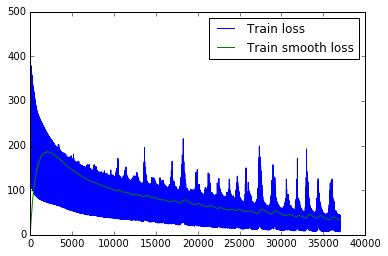

In [6]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 1000 # epochs
alpha = 1e-3 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 10 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = RNN(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()

plt.show()